In [1]:
import pandas as pd
import matplotlib.pyplot as plt

social = pd.read_csv("Aggregated_reddit_twitter.csv")
crypto = pd.read_csv("transformed_crypto.csv")

C:\Users\Dario\AppData\Local\Temp\ipykernel_21144\1173015917.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  social = pd.read_csv("Aggregated_reddit_twitter.csv")


In [2]:
social["date"] = pd.to_datetime(social["date"])

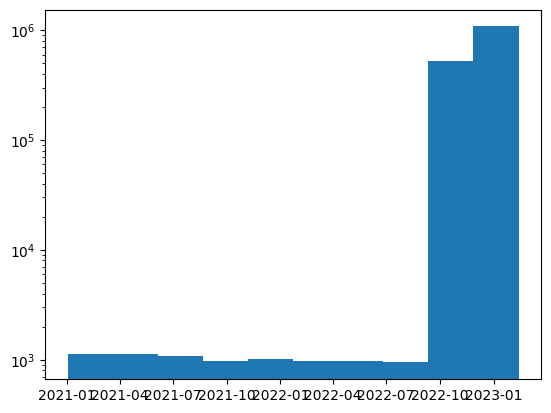

In [3]:
plt.hist(social.date)
plt.yscale("log")
plt.show()

In [5]:
social.dtypes

Unnamed: 0               int64
id                      object
author                  object
replies                float64
likes                  float64
date            datetime64[ns]
content                 object
topics                  object
link                    object
social                  object
title                   object
other_scores           float64
dtype: object

'prova'